In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

size = 400
noise_std = 1e-2
alpha = .1
lr = 1e-3
rank = 15

# # load model
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/4AreasA5_0.pt', map_location='cpu'))


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')



tensor(8.2479)
loss=0.379, acc=0.981


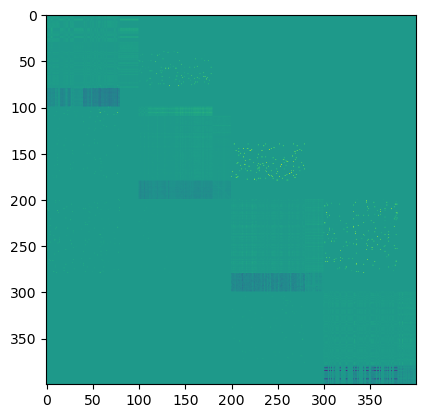

In [2]:
from matplotlib import pyplot as plt
plt.imshow(net.w_rec_eff)

wrec = net.w_rec_eff.numpy()


# Plot psth

In [ ]:


traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]



trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

area = np.arange(0,400)

dim = trajLow.shape
firingRatesAverage = np.zeros((400,2,2,dim[1]))

firingRatesAverage[:,0,0,:] = (trajLow[0,:,area])
firingRatesAverage[:,0,1,:] = (trajLow[1,:,area])
firingRatesAverage[:,1,0,:] = (trajLow[2,:,area])
firingRatesAverage[:,1,1,:] = (trajLow[3,:,area])


# for n in range(140,150):
#     plt.figure()
#     plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
#     plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
#     plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
#     plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
#     plt.title("TF unit: " + str(n))

In [18]:
firingRatesAverage = np.zeros((400,2,2,211))
firingRatesAverage[:,0,0,:] = np.transpose(np.mean(tfRL, axis = 0))
firingRatesAverage[:,0,1,:] = np.transpose(np.mean(tfRR, axis = 0))
firingRatesAverage[:,1,0,:] = np.transpose(np.mean(tfGL, axis = 0))
firingRatesAverage[:,1,1,:] = np.transpose(np.mean(tfGR, axis = 0))

results = {
    'wrec':wrec,
    'firingratesaverage': firingRatesAverage}

import scipy.io as sio
sio.savemat('../results.mat', results)

In [85]:
# umap 

import umap

a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)


frAve = np.zeros((a.shape[1], a.shape[0], 4))

frAve[:,:,0] = np.transpose(a)
frAve[:,:,1] = np.transpose(b)
frAve[:,:,2] = np.transpose(c)
frAve[:,:,3] = np.transpose(d)

# subtract mean
for ii in range(frAve.shape[0]):
    for jj in range(4):
        frAve[ii,:,jj] = frAve[ii,:,jj] - np.mean(frAve[ii,:,:],axis = 1)
    


# fr = np.concatenate((a,b,c,d), axis=0)


fr = np.zeros((400, 844))

for ii in range(frAve.shape[0]):
    temp = np.zeros((844,))
    temp[:211] = frAve[ii,:,0]
    temp[211:211*2] = frAve[ii,:,1]
    temp[211*2:211*3] = frAve[ii,:,2]
    temp[211*3:211*4] = frAve[ii,:,3]
    
    fr[ii,:] = temp    



area = np.arange(0,100)
psthRaw = fr[area,:]


In [8]:
frAve.shape

(400, 211, 4)

In [86]:

# Normalize each row to [0, 1]
data_min = np.min(psthRaw, axis=1, keepdims=True)
data_max = np.max(psthRaw, axis=1, keepdims=True)
psth = (psthRaw - data_min) / (data_max - data_min) 

# or no normalizing
# psth = psthRaw


psthArea = np.zeros((psth.shape[0], a.shape[0], 4))
psthArea[:,:,0] = psth[:,:211]
psthArea[:,:,1] = psth[:,211:211*2]
psthArea[:,:,2] = psth[:,211*2:211*3]
psthArea[:,:,3] = psth[:,211*3:211*4]

/home/tianwang/anaconda3/envs/pyt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


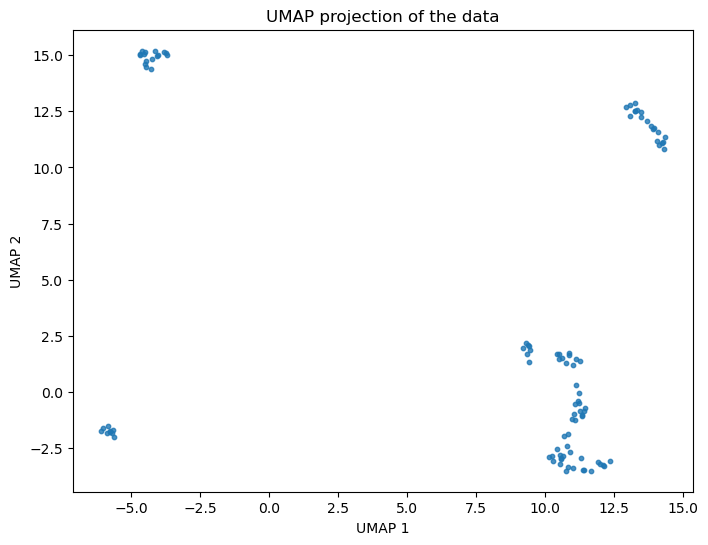

In [87]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(psth)  # shape will be (844, 2)

# Step 2: Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.8)
plt.title("UMAP projection of the data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



/home/tianwang/anaconda3/envs/pyt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


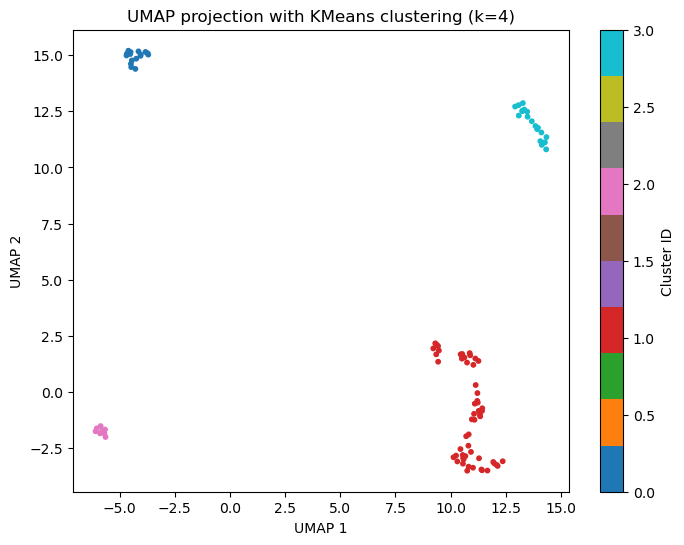

In [94]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(psth)  # data: (844, 100)

# Step 2: Try different K for KMeans and pick best using silhouette score
scores = []
range_k = range(2,8)
for k in range_k:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embedding)
    score = silhouette_score(embedding, labels)
    scores.append(score)

# Step 3: Choose best K
best_k = range_k[np.argmax(scores)]
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

# Step 4: Plot UMAP with cluster coloring
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title(f"UMAP projection with KMeans clustering (k={best_k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Cluster ID')
plt.show()

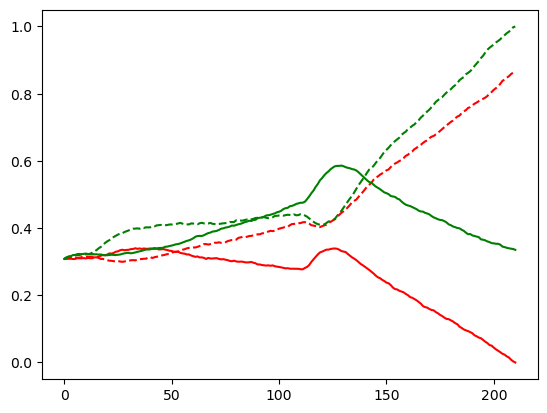

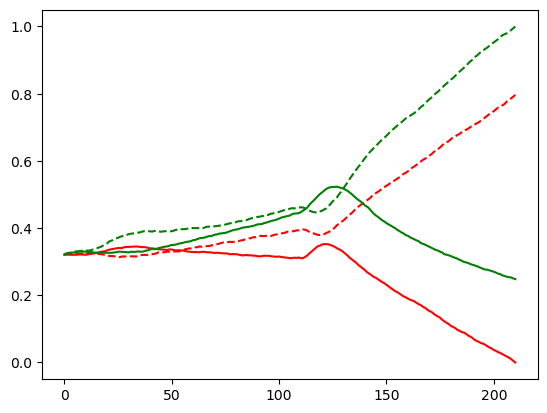

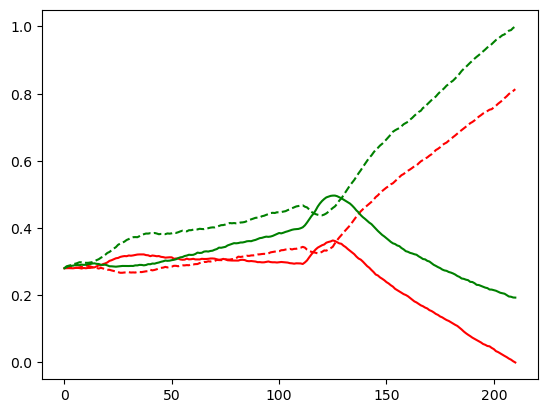

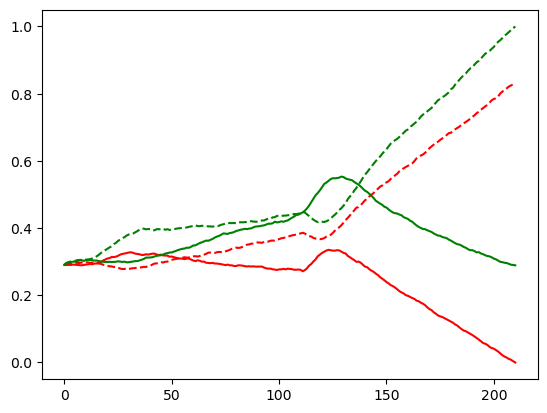

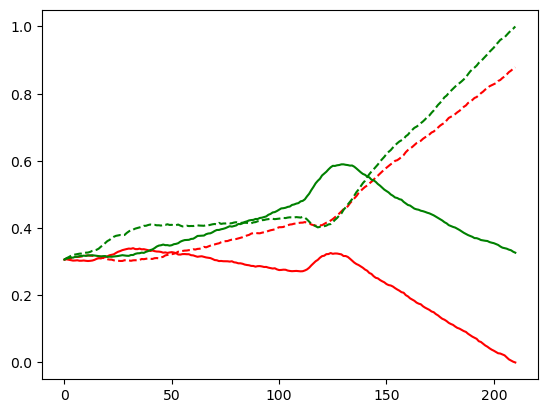

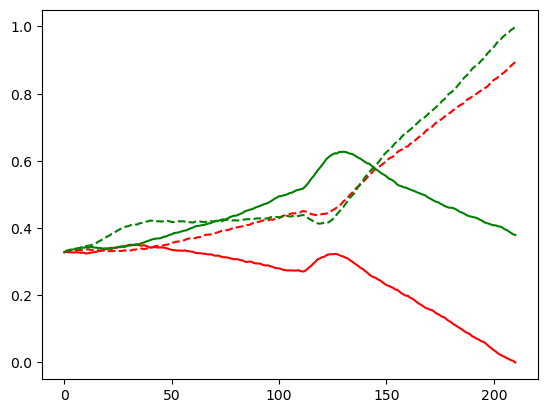

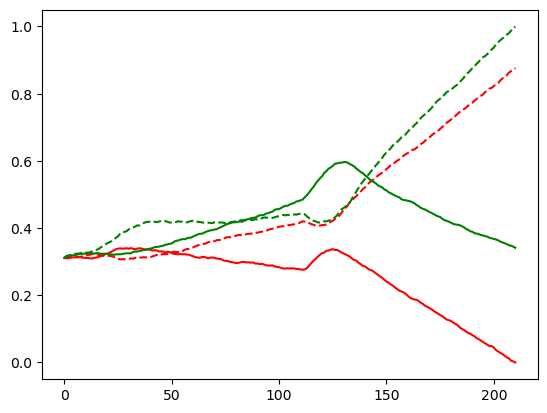

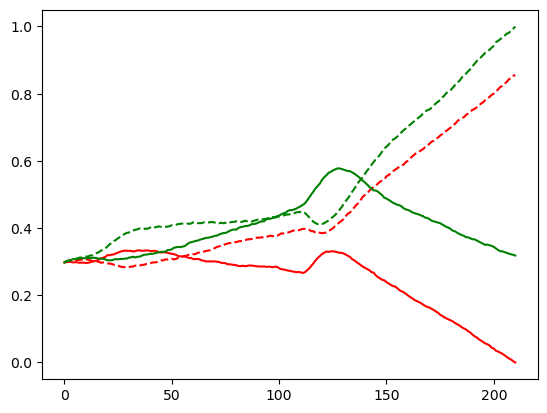

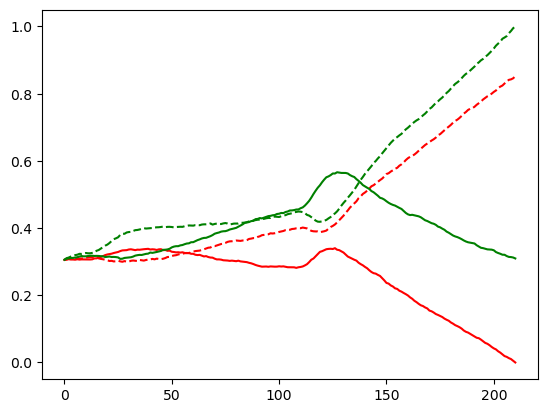

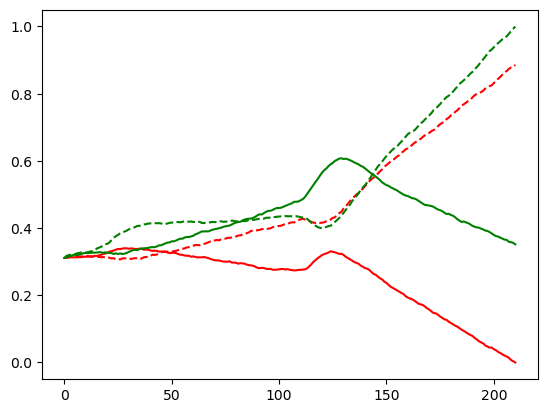

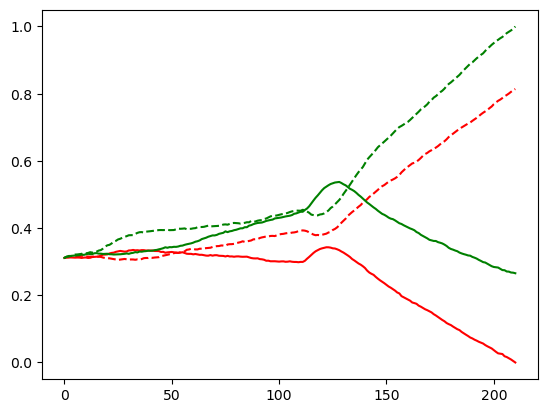

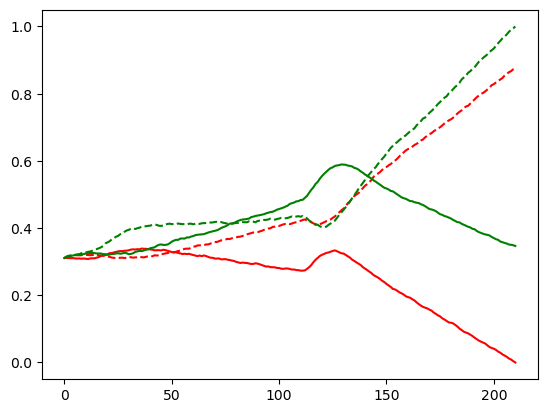

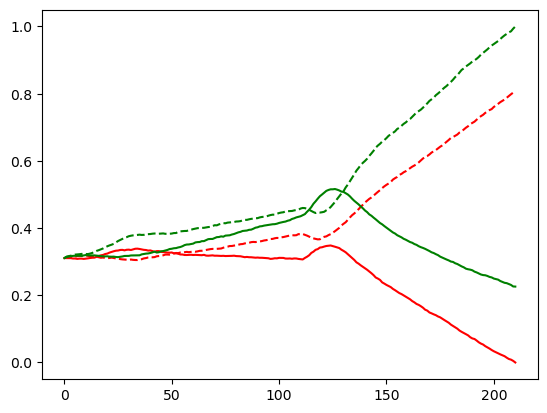

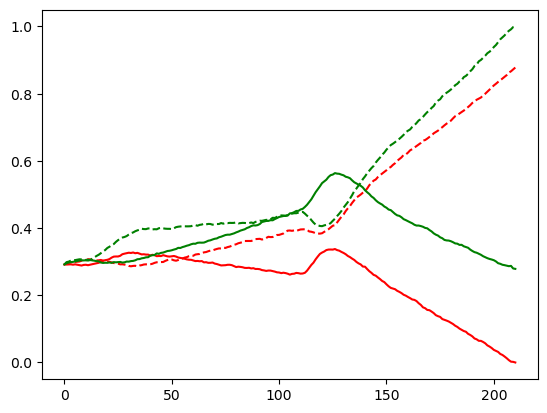

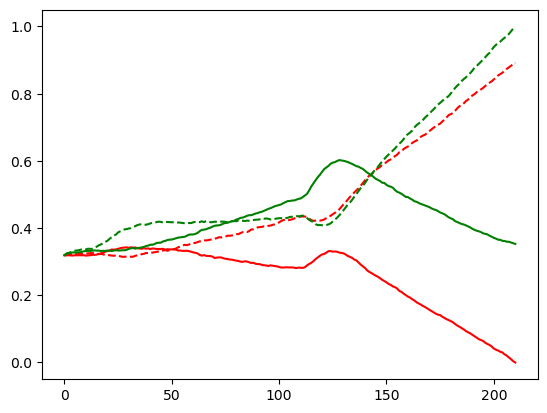

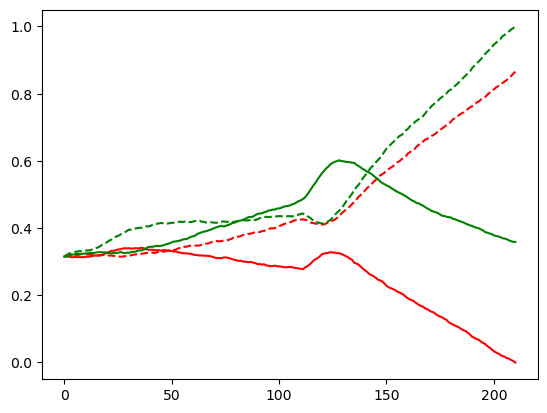

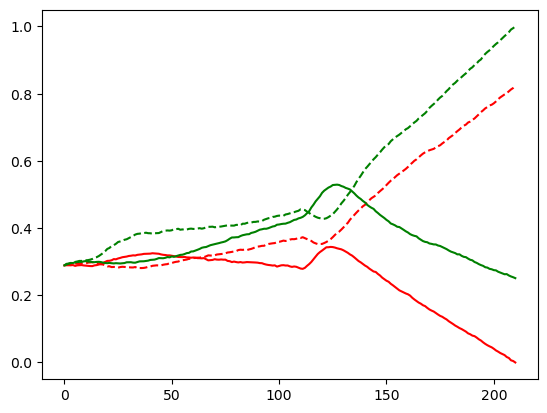

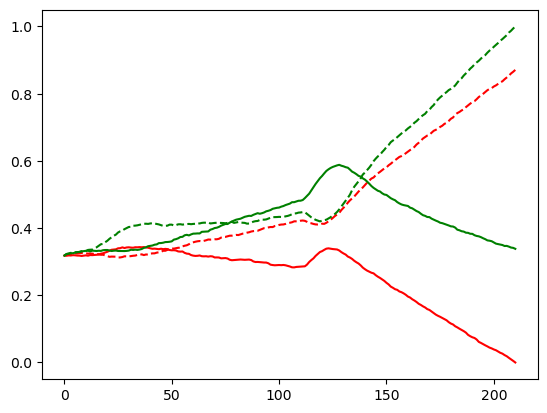

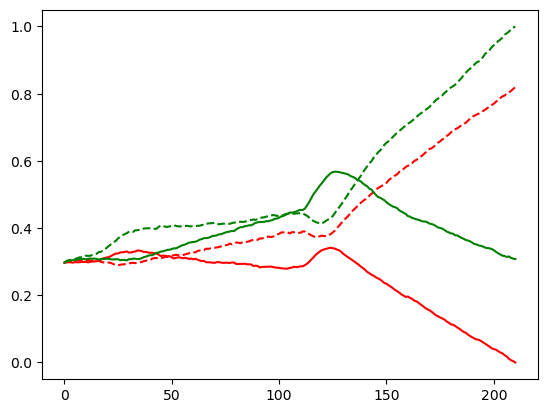

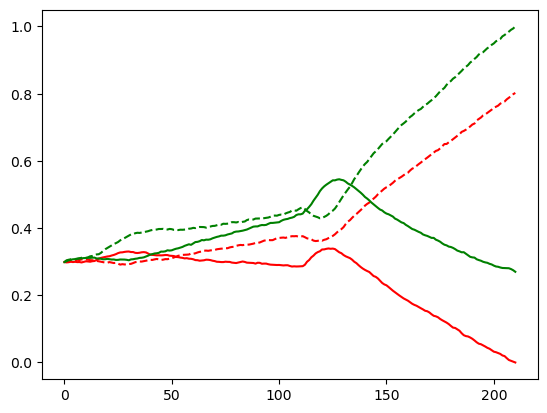

In [92]:

indices = np.where(cluster_labels == 3)[0]
for ii in indices:
    plt.plot(psthArea[ii,:,0], 'r-')
    plt.plot(psthArea[ii,:,1], 'r--')
    plt.plot(psthArea[ii,:,2], 'g-')
    plt.plot(psthArea[ii,:,3], 'g--')
    plt.show()

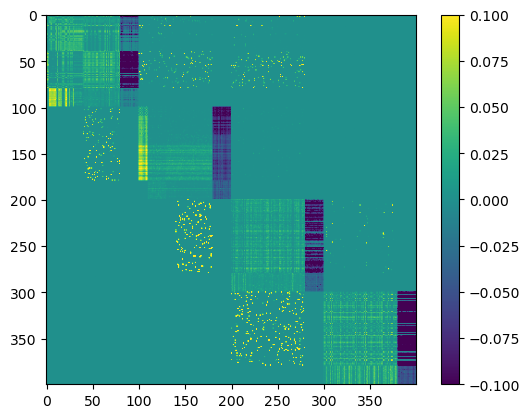

In [53]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

wrec = np.transpose(wrec.detach().numpy())
plt.imshow(wrec)
plt.colorbar()

plt.set_cmap('viridis')
plt.clim(-0.1, 0.1)
plt.show()


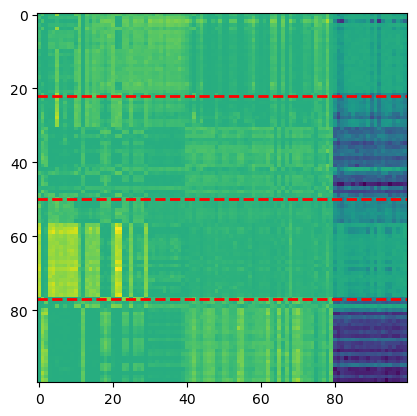

In [54]:
indices0 = np.where(cluster_labels == 0)[0]

indices1 = np.where(np.isin(cluster_labels, [1, 4]))[0]
indices2 = np.where(cluster_labels == 2)[0]
indices3 = np.where(cluster_labels == 3)[0]

indices = np.concatenate((indices0, indices1, indices2, indices3), axis= 0)


area1 = wrec[:100,:100]
# area2 = wrec[100:200,:100]

plt.imshow(area1[indices,:])


plt.axhline(y=indices0.shape[0], color='red', linestyle='--', linewidth=2)
plt.axhline(y=indices1.shape[0] + indices0.shape[0], color='red', linestyle='--', linewidth=2)
plt.axhline(y=indices2.shape[0] + indices1.shape[0] + indices0.shape[0], color='red', linestyle='--', linewidth=2)


In [55]:
indices1.shape

(28,)

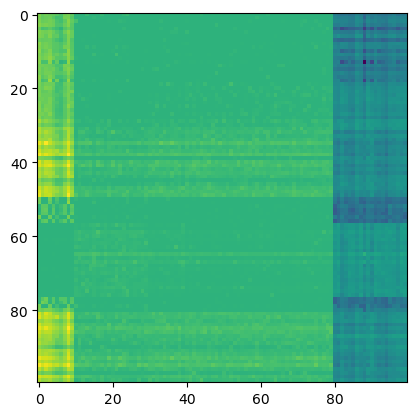

In [57]:
indices1 = np.where(np.isin(cluster_labels, [0, 1, 4]))[0]
indices2 = np.where(cluster_labels == 2)[0]
indices3 = np.where(cluster_labels == 3)[0]

indices = np.concatenate((indices1, indices2, indices3), axis= 0)


area2 = wrec[100:200,100:200]
# area2 = wrec[100:200,:100]

plt.imshow(area2[indices,:])




In [58]:
indices3

array([ 1,  2,  5, 12, 42, 43, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 62,
       65, 67, 69, 70, 71, 79])